In [154]:
import os

# When on Aura, it is important to first set CUDA_VISIBLE_DEVICES environment variable directly from notebook
# For available GPUs, see https://www.fi.muni.cz/tech/unix/aura.html.cs
# Must be done before any related package that leverages cuda is imported
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-56c53afb-6f08-5e5b-83fa-32fc6f09eeb0"
os.environ["TOKENIZERS_PARALLELISM"] = "FALSE"

from sklearn.dummy import DummyClassifier
from rapidfuzz import fuzz
from sec_certs.model.references.segment_extractor import ReferenceSegmentExtractor
import spacy
import numpy as np
import torch
import pandas as pd
from pathlib import Path
from sec_certs.model.references.annotator import ReferenceAnnotator
from sec_certs.model.references.annotator_trainer import ReferenceAnnotatorTrainer
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import umap.plot
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.spatial import ConvexHull, distance_matrix, QhullError
from scipy.stats import skew, kurtosis
from collections import Counter
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import ClassifierMixin
from typing import Literal
from sec_certs.dataset import CCDataset
from sec_certs.utils.nlp import prec_recall_metric
from typing import Final

REPO_ROOT = Path(".").resolve()
DATASET_PATH = REPO_ROOT / "dataset/cc_final_run_may_23/dataset.json"
TENSORBOARD_DATA_DIR = REPO_ROOT / "dataset/tensorboard_visualisation/"
TRAINED_MODEL_PATH = REPO_ROOT / "dataset/reference_prediction/final_model"

print(f"GPU available: {torch.cuda.is_available()}")

nlp = spacy.load("en_core_web_sm")

RANDOM_STATE: Final[int] = 42
MODES = Literal["training", "evaluation", "production"]
EMBEDDING_METHOD = Literal["tf_idf", "transformer"]


GPU available: True


In [172]:
def extract_segments(cc_dset: CCDataset, mode: MODES) -> pd.DataFrame:
    df = ReferenceSegmentExtractor()(list(cc_dset.certs.values()))
    if mode == "training":
        return df.loc[(df.label.notnull()) & ((df.split == "train") | (df.split == "valid"))]
    elif mode == "evaluation":
        return df.loc[df.label.notnull()]
    elif mode == "production":
        return df
    else:
        raise ValueError(f"Unknown mode {mode}")


def _build_transformer_embeddings(segments: pd.DataFrame, mode: MODES, model_path: Path | None = None) -> pd.DataFrame:
    should_save_model = model_path is None
    annotator = None
    if model_path:
        try:
            annotator = ReferenceAnnotator.from_pretrained(model_path)
            should_save_model = False
        except Exception as e:
            print(f"Failed to load ReferenceAnnotator from {model_path}.")
            should_save_model = True

    if not annotator:
        print(f"Training ReferenceAnnotator from scratch.")
        trainer = ReferenceAnnotatorTrainer.from_df(
            segments,
            prec_recall_metric,
            mode=mode,
            n_iterations=20,
            n_epochs=1,
            batch_size=16,
            segmenter_metric="f1",
            ensemble_soft_voting_power=2,
        )
        trainer.train()
        annotator = trainer.clf

    if should_save_model:
        annotator.save_pretrained(model_path)

    return segments.copy().assign(embeddings=lambda df_: df_.segments.map(annotator._model.model_body.encode))


def _build_tf_idf_embeddings(segments: pd.DataFrame, mode: MODES) -> pd.DataFrame:
    def choose_values_to_fit(df_: pd.DataFrame) -> list[str]:
        if mode == "training":
            return df_.loc[df_.split == "train"].copy().explode("segments").segments.values
        elif mode == "evaluation":
            return df_.loc[df_.split != "test"].copy().explode("segments").segments.values
        elif mode == "production":
            return df_.copy().explode("segments").segments.values
        else:
            raise ValueError(f"Unknown mode {mode}")

    tf_idf = TfidfVectorizer()
    tf_idf = tf_idf.fit(choose_values_to_fit(segments))

    return segments.copy().assign(
        embeddings=lambda df_: df_.segments.map(lambda x: tf_idf.transform(x).toarray().tolist())
    )


def build_embeddings(
    segments: pd.DataFrame, mode: MODES, method: EMBEDDING_METHOD, model_path: Path | None = None
) -> pd.DataFrame:
    return (
        _build_transformer_embeddings(segments, mode, model_path)
        if method == "transformer"
        else _build_tf_idf_embeddings(segments, mode)
    )


def extract_language_features(df: pd.DataFrame, cc_dset: CCDataset) -> pd.DataFrame:
    def strip_all(text: str, to_strip) -> str:
        if pd.isna(to_strip):
            return text
        for i in to_strip:
            text = text.replace(i, "")
        return text

    def compute_ngram_overlap_spacy(string1, string2, n):
        doc1 = nlp(string1)
        doc2 = nlp(string2)

        ngrams1 = [" ".join([token.text for token in doc1[i : i + n]]) for i in range(len(doc1) - n + 1)]
        ngrams2 = [" ".join([token.text for token in doc2[i : i + n]]) for i in range(len(doc2) - n + 1)]

        overlap = sum((Counter(ngrams1) & Counter(ngrams2)).values())
        return overlap

    def compute_character_ngram_overlap(str1, str2, n):
        ngrams1 = [str1[i : i + n] for i in range(len(str1) - n + 1)]
        ngrams2 = [str2[i : i + n] for i in range(len(str2) - n + 1)]
        overlap = sum((Counter(ngrams1) & Counter(ngrams2)).values())
        return overlap

    def compute_common_length(str1, str2, prefix=True):
        length = 0
        min_length = min(len(str1), len(str2))
        if prefix:
            for i in range(min_length):
                if str1[i] == str2[i]:
                    length += 1
                else:
                    break
        else:
            for i in range(1, min_length + 1):
                if str1[-i] == str2[-i]:
                    length += 1
                else:
                    break
        return length

    def compute_numeric_token_overlap(str1, str2):
        doc1 = nlp(str1)
        doc2 = nlp(str2)

        tokens1 = [token.text for token in doc1 if token.like_num]
        tokens2 = [token.text for token in doc2 if token.like_num]

        overlap = sum((Counter(tokens1) & Counter(tokens2)).values())
        return overlap

    def extract_language_features(base_name: str, referenced_name: str) -> tuple:
        common_numeric_words = compute_numeric_token_overlap(base_name, referenced_name)
        common_words = compute_ngram_overlap_spacy(base_name, referenced_name, 1)
        bigram_overlap = compute_ngram_overlap_spacy(base_name, referenced_name, 2)
        trigram_overlap = compute_ngram_overlap_spacy(base_name, referenced_name, 3)
        common_prefix_len = compute_common_length(base_name, referenced_name, True)
        common_suffix_len = compute_common_length(base_name, referenced_name, False)
        character_bigram_overlap = compute_character_ngram_overlap(base_name, referenced_name, 2)
        character_trigram_overlap = compute_character_ngram_overlap(base_name, referenced_name, 3)
        base_len = len(base_name)
        referenced_len = len(referenced_name)
        len_difference = abs(base_len - referenced_len)

        return (
            common_numeric_words,
            common_words,
            bigram_overlap,
            trigram_overlap,
            common_prefix_len,
            common_suffix_len,
            character_bigram_overlap,
            character_trigram_overlap,
            base_len,
            referenced_len,
            len_difference,
        )

    certs = list(cc_dset.certs.values())
    dgst_to_cert_name = {x.dgst: x.name for x in certs}
    cert_id_to_cert_name = {x.heuristics.cert_id: x.name for x in certs}
    dgst_to_extracted_versions = {x.dgst: x.heuristics.extracted_versions for x in certs}
    cert_id_to_extracted_versions = {x.heuristics.cert_id: x.heuristics.extracted_versions for x in certs}

    df_lang = (
        df.copy()
        .assign(
            cert_name=lambda df_: df_.dgst.map(dgst_to_cert_name),
            referenced_cert_name=lambda df_: df_.canonical_reference_keyword.map(cert_id_to_cert_name),
            cert_versions=lambda df_: df_.dgst.map(dgst_to_extracted_versions),
            referenced_cert_versions=lambda df_: df_.canonical_reference_keyword.map(cert_id_to_extracted_versions),
            cert_name_stripped_version=lambda df_: df_.apply(
                lambda x: strip_all(x["cert_name"], x["cert_versions"]), axis=1
            ),
            referenced_cert_name_stripped_version=lambda df_: df_.apply(
                lambda x: strip_all(x["referenced_cert_name"], x["referenced_cert_versions"]), axis=1
            ),
            lang_token_set_ratio=lambda df_: df_.apply(
                lambda x: fuzz.token_set_ratio(
                    x["cert_name_stripped_version"], x["referenced_cert_name_stripped_version"]
                ),
                axis=1,
            ),
            lang_partial_ratio=lambda df_: df_.apply(
                lambda x: fuzz.partial_ratio(
                    x["cert_name_stripped_version"], x["referenced_cert_name_stripped_version"]
                ),
                axis=1,
            ),
            lang_token_sort_ratio=lambda df_: df_.apply(
                lambda x: fuzz.token_sort_ratio(
                    x["cert_name_stripped_version"], x["referenced_cert_name_stripped_version"]
                ),
                axis=1,
            ),
            lang_n_segments=lambda df_: df_.segments.map(lambda x: len(x) if x else 0),
        )
        .assign(
            lang_n_extracted_versions=lambda df_: df_.cert_versions.map(lambda x: len(x) if x else 0),
            lang_n_intersection_versions=lambda df_: df_.apply(
                lambda x: len(set(x["cert_versions"]).intersection(set(x["referenced_cert_versions"]))), axis=1
            ),
        )
    )

    df_lang_other_features = df_lang.apply(
        lambda row: extract_language_features(row["cert_name"], row["referenced_cert_name"]), axis=1
    ).apply(pd.Series)
    lang_features = [
        "common_numeric_words",
        "common_words",
        "bigram_overlap",
        "trigram_overlap",
        "common_prefix_len",
        "common_suffix_len",
        "character_bigram_overlap",
        "character_trigram_overlap",
        "base_len",
        "referenced_len",
        "len_difference",
    ]
    df_lang_other_features.columns = ["lang_" + x for x in lang_features]

    return pd.concat([df_lang, df_lang_other_features], axis=1)


def perform_dimensionality_reduction(df: pd.DataFrame, mode: MODES) -> pd.DataFrame:
    def choose_values_to_fit(df_: pd.DataFrame):
        if mode == "training":
            return df_.loc[df_.split == "train"].copy().embeddings.values
        elif mode == "evaluation":
            return df_.loc[df_.split != "test"].copy().embeddings.values
        elif mode == "production":
            return df_.copy().embeddings.values
        else:
            raise ValueError(f"Unknown mode {mode}")

    def choose_labels_to_fit(df_: pd.DataFrame):
        if mode == "training":
            return df_.loc[df_.split == "train"].copy().label.values
        elif mode == "evaluation":
            return df_.loc[df_.split != "test"].copy().label.values
        elif mode == "production":
            return df_.copy().label.values
        else:
            raise ValueError(f"Unknown mode {mode}")

    df_exploded = df.copy().explode(["segments", "embeddings"]).reset_index(drop=True)
    label_encoder = LabelEncoder()

    embeddings_to_fit = np.vstack(choose_values_to_fit(df_exploded))
    labels_to_fit = label_encoder.fit_transform(choose_labels_to_fit(df_exploded))

    scaler = StandardScaler()
    embeddings_to_fit_scaled = scaler.fit_transform(embeddings_to_fit)

    # parallel UMAP not available with random state
    umapper = umap.UMAP(n_neighbors=5, random_state=RANDOM_STATE, n_jobs=1).fit(embeddings_to_fit, y=labels_to_fit)
    pca_mapper = PCA(n_components=2, random_state=RANDOM_STATE).fit(embeddings_to_fit_scaled, y=labels_to_fit)

    all_embeddings = np.vstack(df.embeddings.values)
    all_embeddings_scaled = scaler.transform(all_embeddings)

    df_exploded["umap"] = umapper.transform(all_embeddings).tolist()
    df_exploded["pca"] = pca_mapper.transform(all_embeddings_scaled).tolist()

    return (
        df_exploded.groupby(["dgst", "canonical_reference_keyword"])
        .agg(
            {
                "segments": lambda x: x.tolist(),
                "actual_reference_keywords": "first",
                "label": "first",
                "split": "first",
                "embeddings": lambda x: x.tolist(),
                "umap": lambda x: x.tolist(),
                "pca": lambda x: x.tolist(),
            }
        )
        .reset_index()
    )


def extract_geometrical_features(df: pd.DataFrame) -> pd.DataFrame:
    def extract_features(points):
        # Convert list of points to a numpy array
        points = np.array(points)
        xs = points[:, 0]
        ys = points[:, 1]

        # Basic Descriptive Statistics
        mean_x, mean_y = np.mean(xs), np.mean(ys)
        var_x, var_y = np.var(xs), np.var(ys)
        std_x, std_y = np.std(xs), np.std(ys)
        if len(points) > 1:
            skew_x, skew_y = skew(xs), skew(ys)
            kurt_x, kurt_y = kurtosis(xs), kurtosis(ys)
        else:
            skew_x, skew_y = 0, 0
            kurt_x, kurt_y = 0, 0

        # Spatial Spread
        range_x, range_y = np.ptp(xs), np.ptp(ys)
        cov_xy = np.cov(xs, ys)[0, 1] if len(points) > 1 else 0
        median_x, median_y = np.median(xs), np.median(ys)

        # Distance-based Features
        centroid = [mean_x, mean_y]
        distances_to_centroid = np.linalg.norm(points - centroid, axis=1) if len(points) > 1 else [0]
        mean_distance = np.mean(distances_to_centroid)
        max_distance = np.max(distances_to_centroid)
        min_distance = np.min(distances_to_centroid)
        std_distance = np.std(distances_to_centroid)
        max_min_distance = max_distance - min_distance

        sorted_points = points[np.argsort(distances_to_centroid)]
        total_distance = np.sum(np.linalg.norm(sorted_points[1:] - sorted_points[:-1], axis=1))

        # Geometric Features
        hull_area, hull_perimeter = (0, 0)
        if len(points) > 2:  # ConvexHull needs at least 3 points
            try:
                hull = ConvexHull(points)
                hull_area = hull.volume
                hull_perimeter = hull.area
            except QhullError:
                pass

        pairwise_distances = distance_matrix(points, points) if len(points) > 1 else np.array([[0]])
        mean_pairwise_distance = np.mean(pairwise_distances)
        max_pairwise_distance = np.max(pairwise_distances)

        if len(points) > 1:
            min_coords = np.min(points, axis=0)
            max_coords = np.max(points, axis=0)
            bounding_box_width = max_coords[0] - min_coords[0]
            bounding_box_height = max_coords[1] - min_coords[1]
            bounding_box_area = bounding_box_width * bounding_box_height

            aspect_ratio = bounding_box_width / bounding_box_height if bounding_box_height != 0 else 1
            point_density = len(points) / bounding_box_area
        else:
            aspect_ratio = 0
            point_density = 0

        # Gather all features into a list
        features = [
            mean_x,
            mean_y,
            var_x,
            var_y,
            std_x,
            std_y,
            skew_x,
            skew_y,
            kurt_x,
            kurt_y,
            range_x,
            range_y,
            cov_xy,
            median_x,
            median_y,
            mean_distance,
            max_distance,
            min_distance,
            max_min_distance,
            std_distance,
            total_distance,
            hull_area,
            hull_perimeter,
            mean_pairwise_distance,
            max_pairwise_distance,
            aspect_ratio,
            point_density,
        ]

        return features

    feature_names = [
        "mean_x",
        "mean_y",
        "var_x",
        "var_y",
        "std_x",
        "std_y",
        "skew_x",
        "skew_y",
        "kurt_x",
        "kurt_y",
        "range_x",
        "range_y",
        "cov_xy",
        "median_x",
        "median_y",
        "mean_distance_to_centroid",
        "max_distance_to_centroid",
        "min_distance_to_centroid",
        "max_min_distance_to_centroid",
        "std_distance_to_centroid",
        "total_distances_to_centroid",
        "hull_area",
        "hull_perimeter",
        "mean_pairwise_distance",
        "max_pairwise_distance",
        "aspect_ratio",
        "point_density",
    ]

    df_features_pca = df.pca.apply(extract_features).apply(pd.Series)
    feature_names_pca = ["pca_" + x for x in feature_names]
    df_features_pca.columns = feature_names_pca

    df_features_umap = df.umap.apply(extract_features).apply(pd.Series)
    feature_names_umap = ["umap_" + x for x in feature_names]
    df_features_umap.columns = feature_names_umap

    return pd.concat([df, df_features_pca, df_features_umap], axis=1)


def build_clf_and_predict(
    df: pd.DataFrame,
    mode: MODES,
    train_baseline: bool = False,
    use_pca: bool = True,
    use_umap: bool = True,
    use_lang: bool = True,
) -> tuple[ClassifierMixin, np.ndarray, np.ndarray, list[str]]:
    def get_data_for_clf(df_: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, list[str]]:
        feature_columns = []
        if not use_pca and not use_umap and not use_lang:
            raise ValueError("At least one of PCA, UMAP or language features must be used.")
        if use_pca:
            feature_columns.extend([x for x in df.columns if x.startswith("pca_")])
        if use_umap:
            feature_columns.extend([x for x in df.columns if x.startswith("umap_")])
        if use_lang:
            feature_columns.extend([x for x in df.columns if x.startswith("lang_")])

        if mode == "training":
            train_df = df_.loc[df_.split == "train"].copy()
            eval_df = df_.loc[df_.split == "valid"].copy()
        elif mode == "evaluation":
            train_df = df_.loc[df_.split != "test"].copy()
            eval_df = df_.loc[df_.split == "test"].copy()
        elif mode == "production":
            train_df = df_.copy()
            eval_df = df_.copy()
        else:
            raise ValueError(f"Unknown mode {mode}")

        X_train = np.vstack(train_df[feature_columns].values)
        y_train = train_df.label.values
        X_eval = np.vstack(eval_df[feature_columns].values)
        y_eval = eval_df.label.values

        return X_train, y_train, X_eval, y_eval, feature_columns

    X_train, y_train, X_eval, y_eval, feature_cols = get_data_for_clf(df)
    if train_baseline:
        clf = DummyClassifier(random_state=RANDOM_STATE)
    else:
        clf = RandomForestClassifier(random_state=RANDOM_STATE)

    clf.fit(X_train, y_train)

    return clf, X_eval, y_eval, feature_cols


def display_dim_red_scatter(df: pd.DataFrame, dim_red: Literal["umap", "pca"]) -> None:
    df_exploded = df.explode(["segments", dim_red]).reset_index()

    x_col = dim_red + "_x"
    y_col = dim_red + "_y"

    df_exploded[x_col] = df_exploded[dim_red].map(lambda x: x[0])
    df_exploded[y_col] = df_exploded[dim_red].map(lambda x: x[1])
    df_exploded["wrapped_segment"] = df_exploded.segments.str.wrap(60).map(lambda x: x.replace("\n", "<br>"))

    fig = px.scatter(
        df_exploded,
        x=x_col,
        y=y_col,
        color="label",
        hover_data=["dgst", "canonical_reference_keyword", "wrapped_segment"],
        width=1500,
        height=1000,
        title=f"{dim_red.upper()} projection of segment embeddings.",
    )
    fig.show()


def evaluate_clf(clf: ClassifierMixin, x_eval: np.ndarray, y_eval: np.ndarray, feature_cols: list[str]):
    y_pred = clf.predict(x_eval)

    print(classification_report(y_eval, y_pred))

    ConfusionMatrixDisplay.from_predictions(
        y_eval,
        y_pred,
        xticks_rotation=90,
    )

    if isinstance(clf, RandomForestClassifier):
        feature_importance = clf.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        features = np.array(feature_cols)[sorted_idx]

        plt.figure(figsize=(10, 12))
        plt.barh(features, feature_importance[sorted_idx], align="center")
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importance in Random Forest")
        plt.tight_layout()
        plt.show()


                   precision    recall  f1-score   support

 COMPONENT_SHARED       0.50      0.50      0.50         2
   COMPONENT_USED       1.00      1.00      1.00        54
EVALUATION_REUSED       0.69      0.85      0.76        13
 PREVIOUS_VERSION       0.75      0.43      0.55         7
    RE-EVALUATION       1.00      1.00      1.00        19

         accuracy                           0.93        95
        macro avg       0.79      0.75      0.76        95
     weighted avg       0.93      0.93      0.92        95



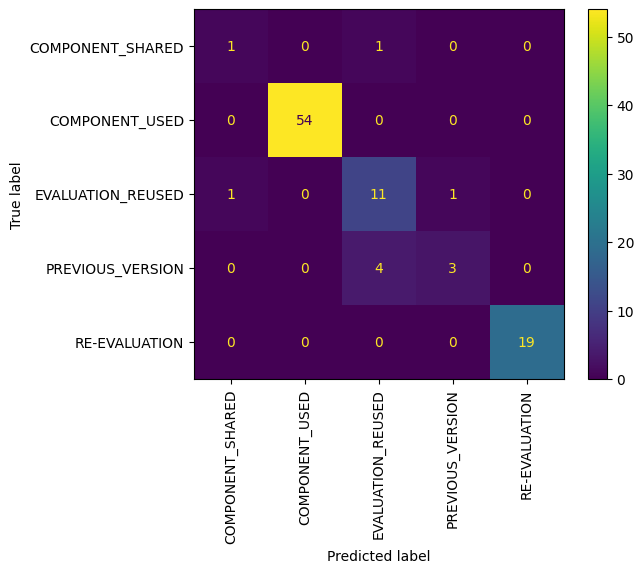

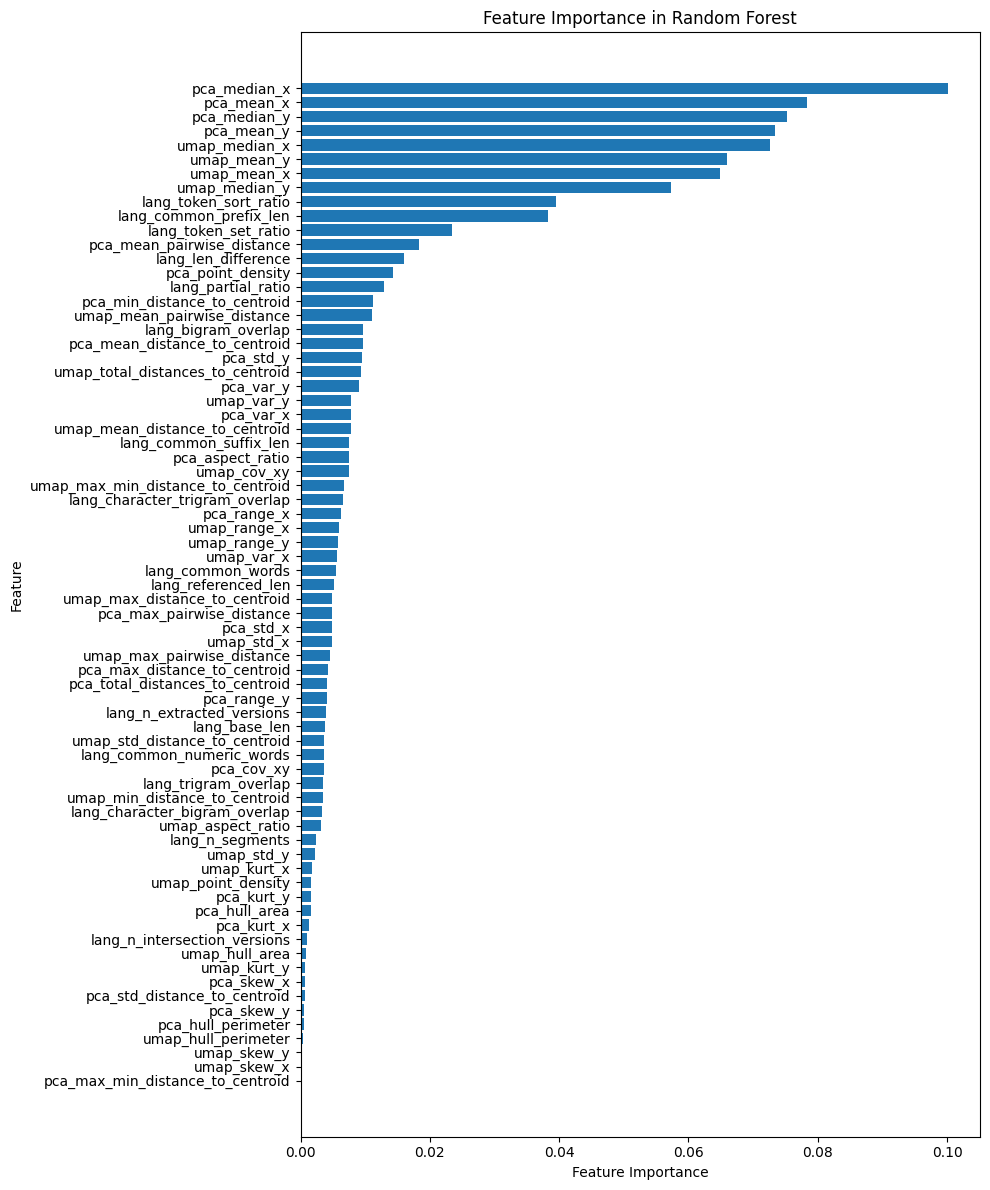

In [173]:
cc_dset = CCDataset.from_json(DATASET_PATH)

# df = extract_segments(cc_dset, mode="training")
# df.to_csv(REPO_ROOT / "dataset/reference_prediction/dataset.csv", index=False)

df = pd.read_csv(REPO_ROOT / "dataset/reference_prediction/dataset.csv")
df.segments = df.segments.apply(literal_eval)
df.actual_reference_keywords = df.actual_reference_keywords.apply(literal_eval)
# df.label = df.label.map(lambda x: np.nan if x == "IRRELEVANT" else x)

mode = "training"
# TODO: Plug this into pandas pipeline
df = build_embeddings(df, mode=mode, method="transformer", model_path=TRAINED_MODEL_PATH)
df = perform_dimensionality_reduction(df, mode=mode)
df = extract_language_features(df, cc_dset)
df = extract_geometrical_features(df)

clf, x_eval, y_eval, feature_cols = build_clf_and_predict(df, mode="training", train_baseline=False)
evaluate_clf(clf, x_eval, y_eval, feature_cols)

# display_dim_red_scatter(df.loc[df.split == "valid"], "umap")
